In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [148]:
df = pd.read_csv("/content/weather_dataset_kota_lengkap.csv")

In [149]:
df.columns = [col.replace("_", "").lower().strip() for col in df.columns]

df.columns

Index(['date', 'debiltcloudcover', 'debiltwindspeed', 'debiltwindgust',
       'debilthumidity', 'debiltpressure', 'debiltglobalradiation',
       'debiltprecipitation', 'debiltsunshine', 'debilttempmean',
       'debilttempmin', 'debilttempmax', 'dusseldorfcloudcover',
       'dusseldorfwindspeed', 'dusseldorfwindgust', 'dusseldorfhumidity',
       'dusseldorfpressure', 'dusseldorfglobalradiation',
       'dusseldorfprecipitation', 'dusseldorfsunshine', 'dusseldorftempmean',
       'dusseldorftempmin', 'dusseldorftempmax', 'maastrichtcloudcover',
       'maastrichtwindspeed', 'maastrichtwindgust', 'maastrichthumidity',
       'maastrichtpressure', 'maastrichtglobalradiation',
       'maastrichtprecipitation', 'maastrichtsunshine', 'maastrichttempmean',
       'maastrichttempmin', 'maastrichttempmax', 'muenchencloudcover',
       'muenchenwindspeed', 'muenchenwindgust', 'muenchenhumidity',
       'muenchenpressure', 'muenchenglobalradiation', 'muenchenprecipitation',
       'muenchensu

In [150]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']
features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation',
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

In [151]:
df_outlier = df.copy()
def detect_outlier_bounds(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, col):
    lower, upper = detect_outlier_bounds(df, col)
    return df[(df[col] >= lower) & (df[col] <= upper)]

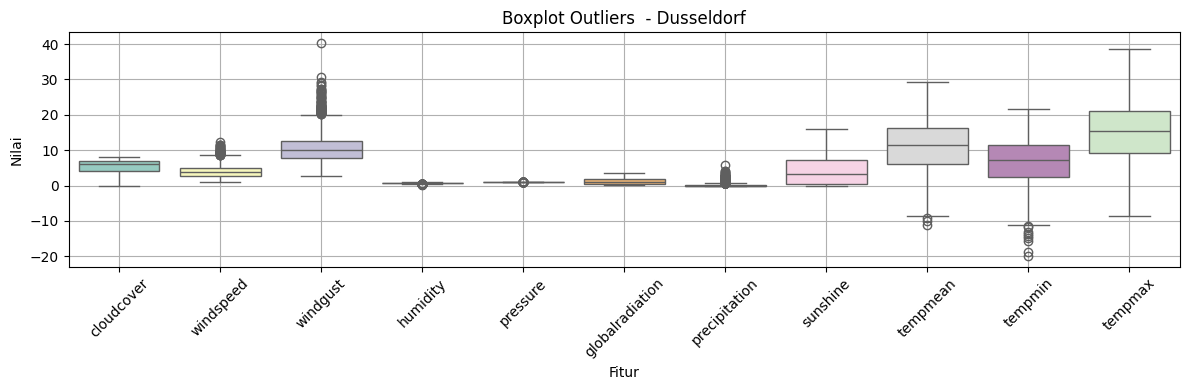

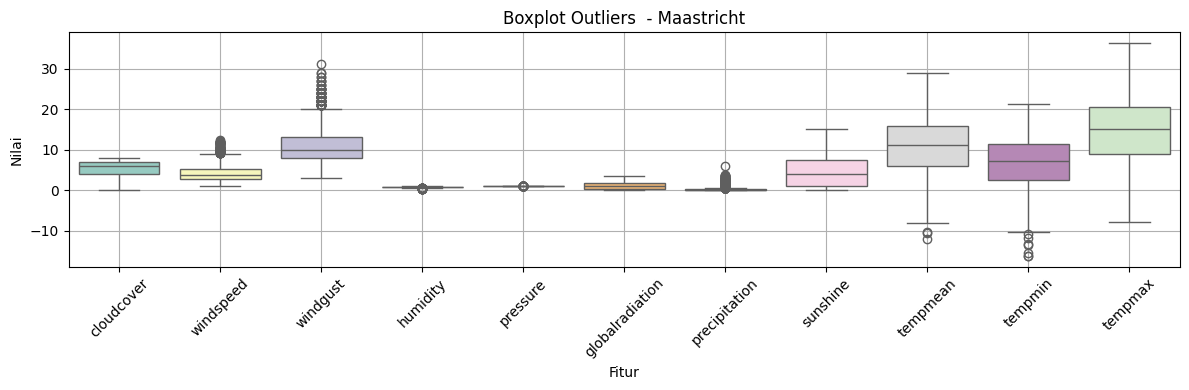

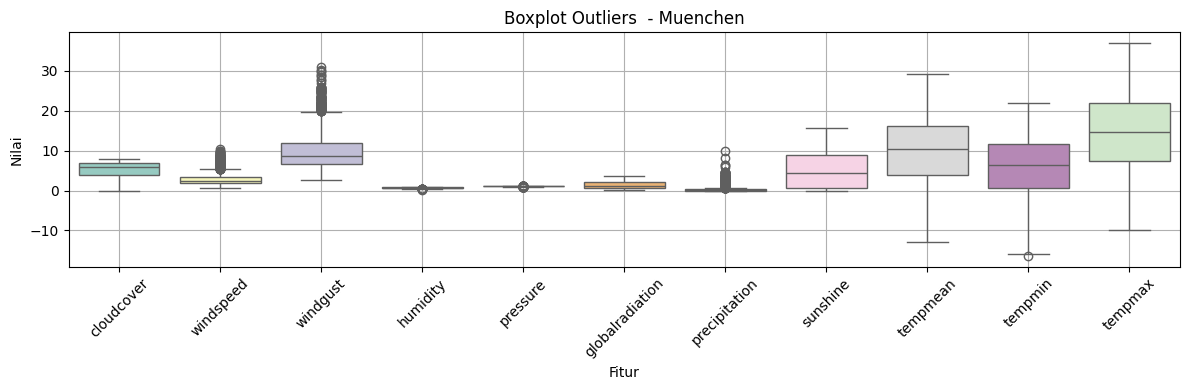

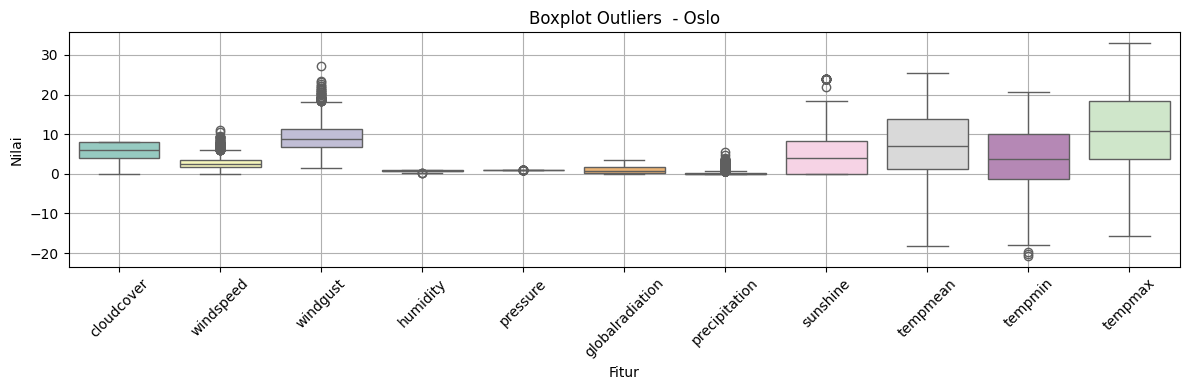

In [152]:
for kota in kota_list:
    kota_cols = [f"{kota}{feature}" for feature in features if f"{kota}{feature}" in df_outlier.columns]

    df_kota = df_outlier[kota_cols].copy()
    df_kota.columns = features
    df_melt = df_kota.melt(var_name="Fitur", value_name="Nilai")

    plt.figure(figsize=(12, 4))
    sns.boxplot(x="Fitur", y="Nilai", hue="Fitur", data=df_melt, palette="Set3", legend=False)
    plt.title(f"Boxplot Outliers  - {kota.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

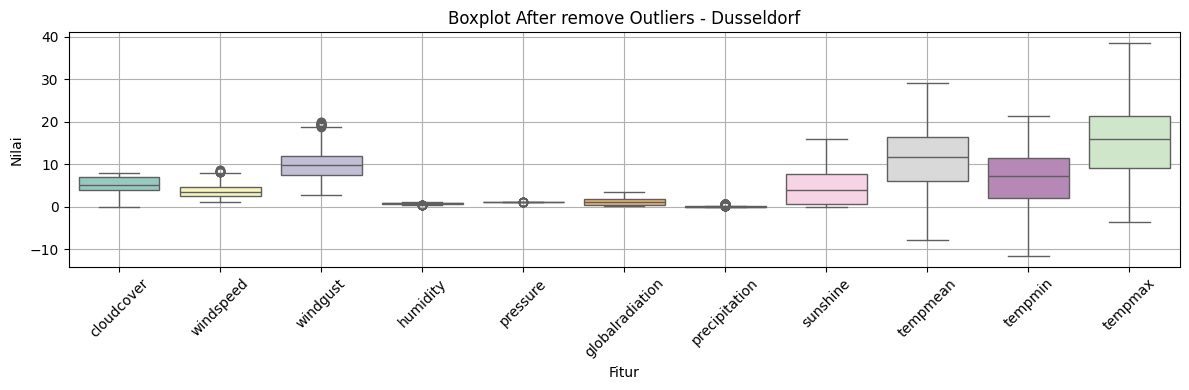

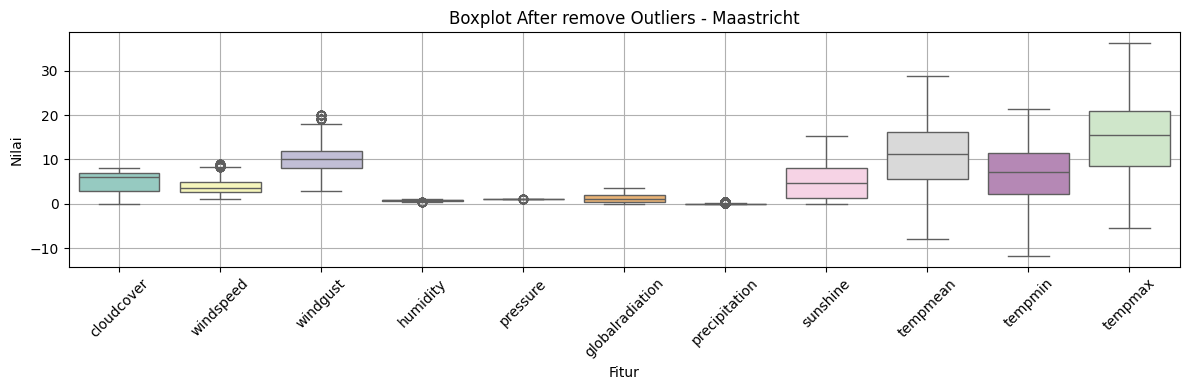

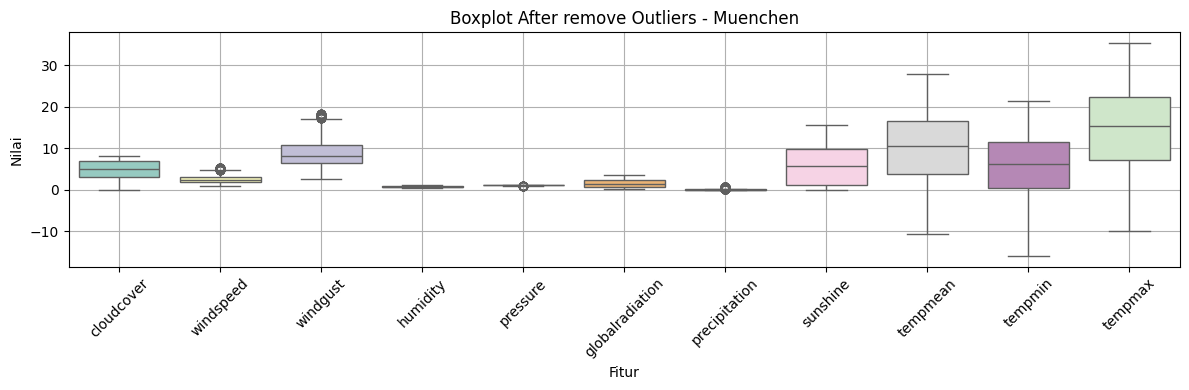

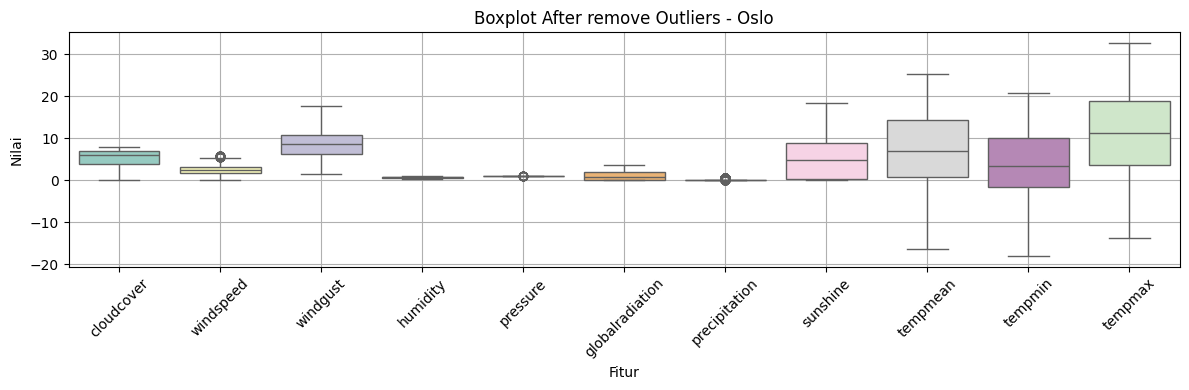

In [153]:
for kota in kota_list:
    kota_cols = [f"{kota}{feature}" for feature in features if f"{kota}{feature}" in df_outlier.columns]

    df_kota = df_outlier[kota_cols].copy()
    df_kota.columns = features


    for col in features:
        df_kota = remove_outliers(df_kota, col)

    df_melt = df_kota.melt(var_name="Fitur", value_name="Nilai")

    plt.figure(figsize=(12, 4))
    sns.boxplot(x="Fitur", y="Nilai", hue="Fitur", data=df_melt, palette="Set3", legend=False)
    plt.title(f"Boxplot After remove Outliers - {kota.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [154]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(df)

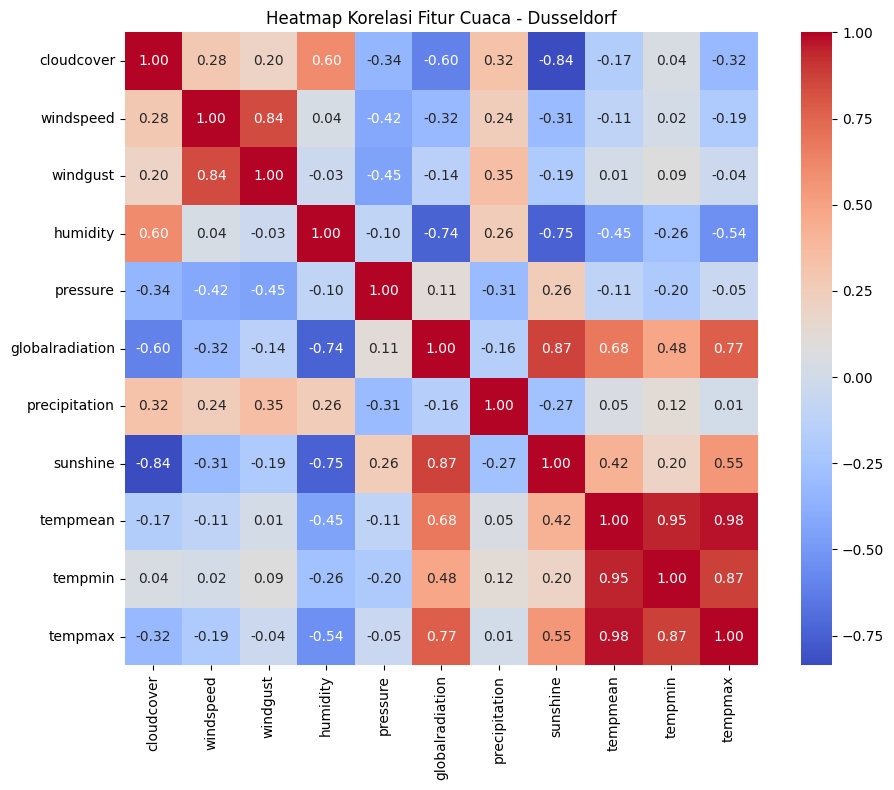

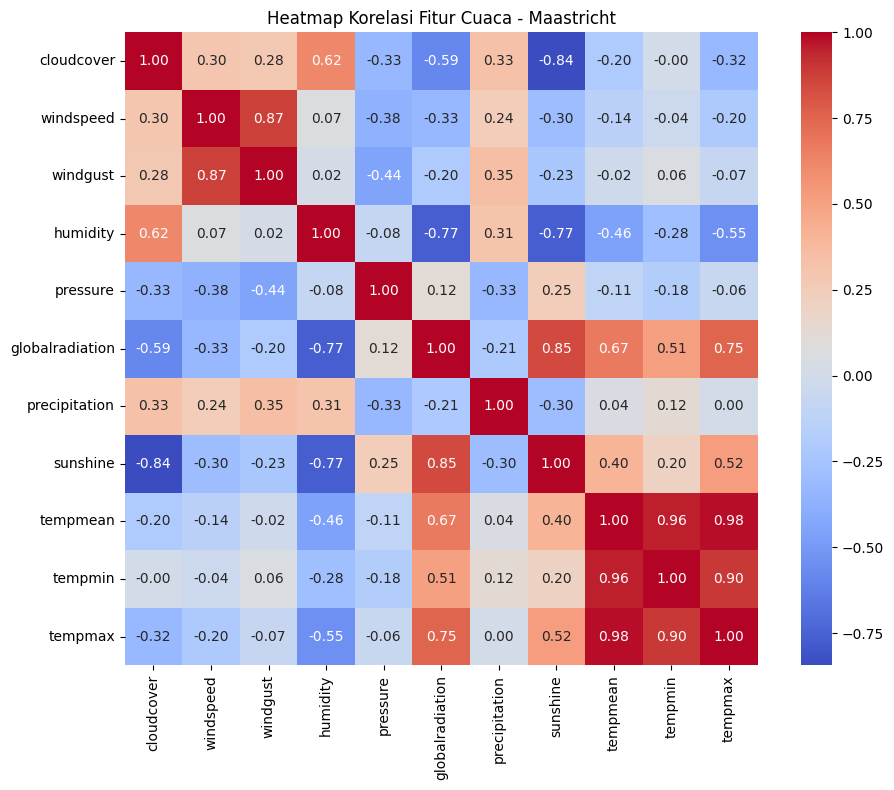

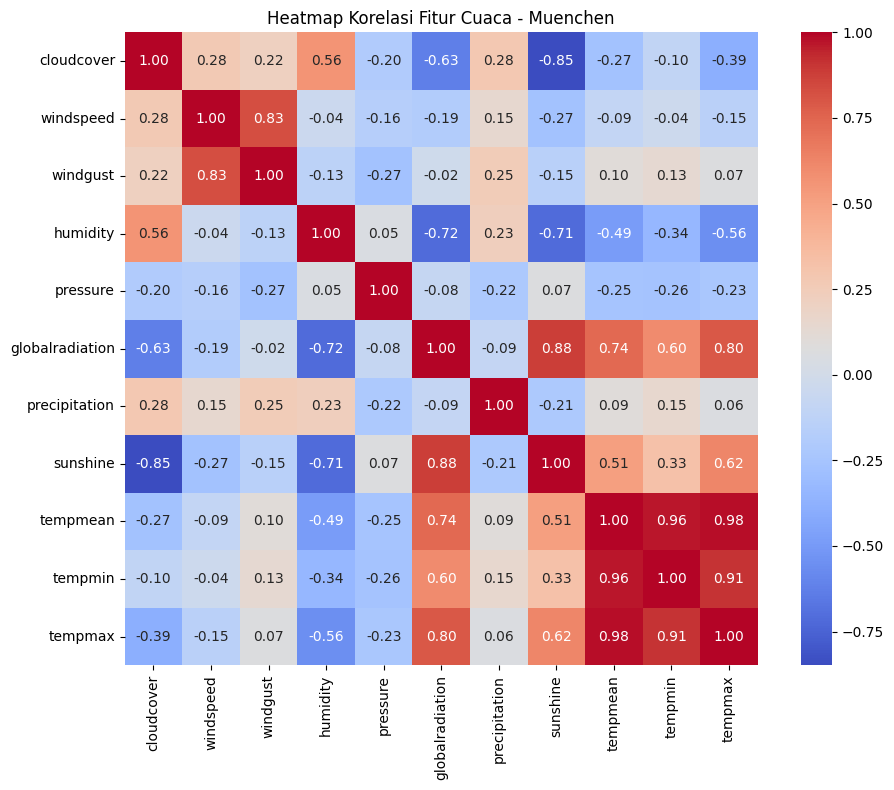

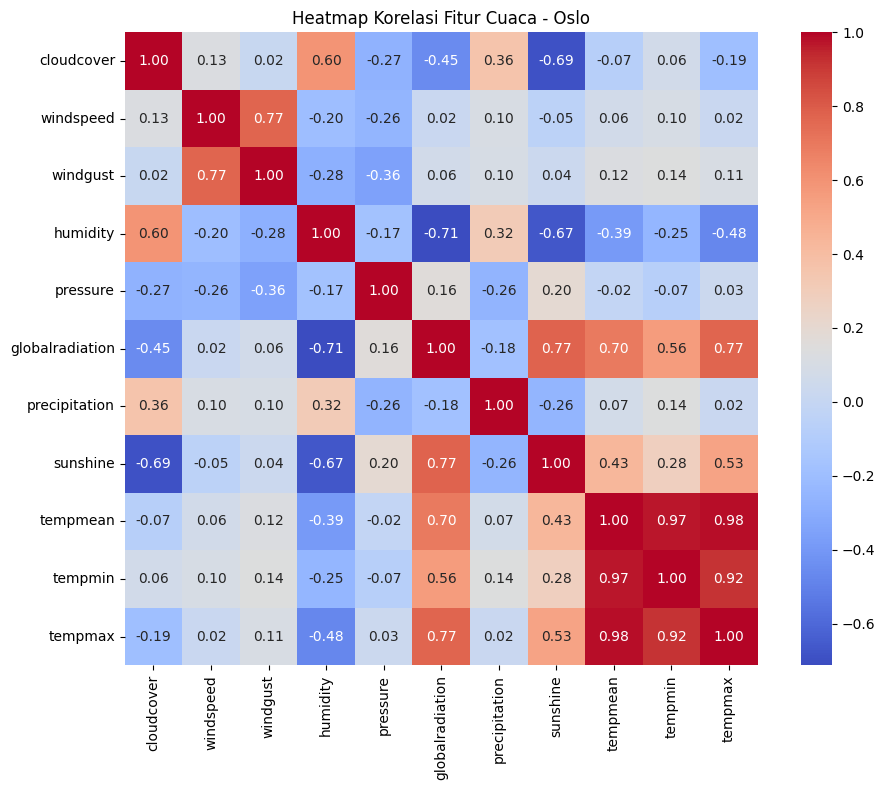

In [155]:
kolom_fitur_kota = [f"{kota}{fitur}" for fitur in features if f"{kota}{fitur}" in df.columns]

for kota in kota_list:
    kota_cols = [col for col in df.columns if col.startswith(kota)]
    kota_cols = sorted(
        kota_cols,
        key=lambda x: features.index(x.replace(kota, "")) if x.replace(kota, "") in features else 99
    )
    renamed_cols = {f"{kota}{feat}": feat for feat in features if f"{kota}{feat}" in kota_cols}

    if not renamed_cols:
        continue
    df_kota = df[list(renamed_cols.keys())].rename(columns=renamed_cols)
    corr = df_kota.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f"Heatmap Korelasi Fitur Cuaca - {kota.capitalize()}")
    plt.tight_layout()
    plt.show()

In [156]:
def create_lags(df, features, lag_days=7):
    for lag in range(1, lag_days + 1):
        for f in features:
            df[f'{f}_lag{lag}'] = df[f].shift(lag)
    return df

In [157]:
models = {}
predictions = {}

In [158]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import xgboost as xgb

for kota in kota_list:
    print(f'\nProcessing city: {kota}')

    kota_cols = [kota + f for f in features]
    df_kota = df[['date'] + kota_cols].copy()
    df_kota.columns = ['date'] + features
    df_kota = df_kota.sort_values('date').reset_index(drop=True)

    df_kota = create_lags(df_kota, features, lag_days=7)

    # Membuat kolom target untuk 7 hari ke depan
    for day_ahead in range(1, 8):
        df_kota[f'precipitation_day{day_ahead}'] = df_kota['precipitation'].shift(-day_ahead)

    df_kota = df_kota.dropna().reset_index(drop=True)
    feature_cols = [col for col in df_kota.columns if 'lag' in col]

    for day_ahead in range(1, 8):
        X = df_kota[feature_cols].values
        y = df_kota[f'precipitation_day{day_ahead}'].values

        # Log-transform target
        y_log = np.log1p(y)

        # Split
        X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
        y_train_log, y_test_log = y_log[:int(0.8*len(y))], y_log[int(0.8*len(y)):]
        y_test_actual = y[int(0.8*len(y)):]  # buat evaluasi asli

        # Fit model pakai target log
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
        model.fit(X_train, y_train_log)

        # Predict dan balikin dari log
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # balik dari log1p

        mse = mean_squared_error(y_test_actual, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_actual, y_pred)

        models[(kota, day_ahead)] = model
        predictions[(kota, day_ahead)] = (np.arange(len(y_test_actual)), y_pred)

        print(f'  Day +{day_ahead} precipitation forecast: MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}')



Processing city: dusseldorf
  Day +1 precipitation forecast: MSE=0.2562, RMSE=0.5062, R2=-0.0664
  Day +2 precipitation forecast: MSE=0.2578, RMSE=0.5078, R2=-0.0729
  Day +3 precipitation forecast: MSE=0.2582, RMSE=0.5082, R2=-0.0747
  Day +4 precipitation forecast: MSE=0.2717, RMSE=0.5213, R2=-0.1195
  Day +5 precipitation forecast: MSE=0.2631, RMSE=0.5129, R2=-0.0813
  Day +6 precipitation forecast: MSE=0.2647, RMSE=0.5145, R2=-0.0880
  Day +7 precipitation forecast: MSE=0.2808, RMSE=0.5299, R2=-0.1538

Processing city: maastricht
  Day +1 precipitation forecast: MSE=0.2088, RMSE=0.4570, R2=-0.0577
  Day +2 precipitation forecast: MSE=0.2253, RMSE=0.4747, R2=-0.1409
  Day +3 precipitation forecast: MSE=0.2159, RMSE=0.4647, R2=-0.0931
  Day +4 precipitation forecast: MSE=0.2140, RMSE=0.4626, R2=-0.0781
  Day +5 precipitation forecast: MSE=0.2165, RMSE=0.4653, R2=-0.0899
  Day +6 precipitation forecast: MSE=0.2253, RMSE=0.4746, R2=-0.1339
  Day +7 precipitation forecast: MSE=0.2258, 

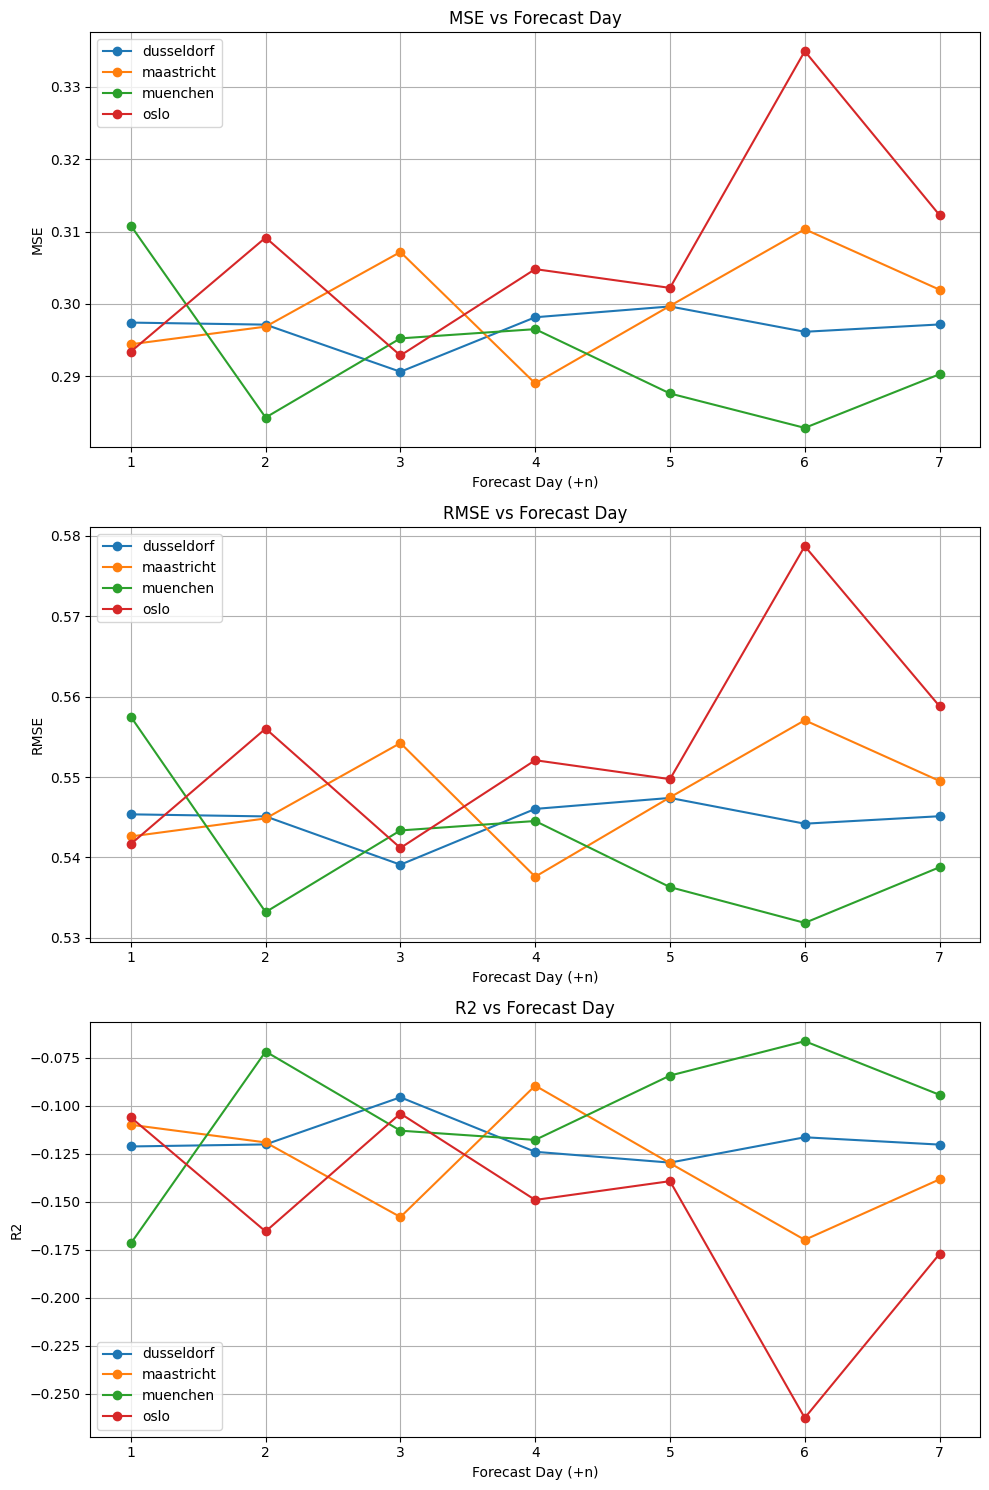

In [159]:
results = []

for (kota, day_ahead), (test_idx, y_pred) in predictions.items():
    X = df_kota[feature_cols]
    y_true = df_kota[f'precipitation_day{day_ahead}'].iloc[test_idx]  # GANTI DI SINI
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        'city': kota,
        'day_ahead': day_ahead,
        'mse': mse,
        'rmse': rmse,
        'r2': r2
    })

results_df = pd.DataFrame(results)

cities = results_df['city'].unique()
metrics = ['mse', 'rmse', 'r2']

fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 15))

for i, metric in enumerate(metrics):
    ax = axs[i]
    for city in cities:
        data = results_df[results_df['city'] == city]
        ax.plot(data['day_ahead'], data[metric], marker='o', label=city)
    ax.set_title(f'{metric.upper()} vs Forecast Day')
    ax.set_xlabel('Forecast Day (+n)')
    ax.set_ylabel(metric.upper())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



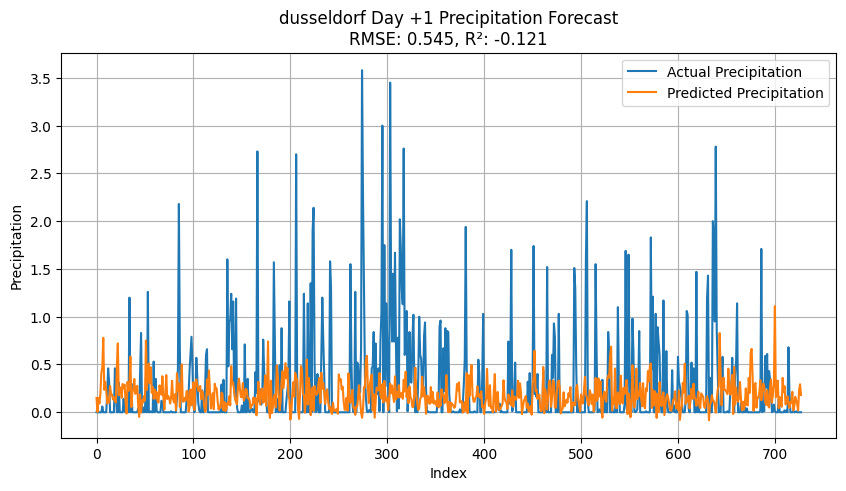

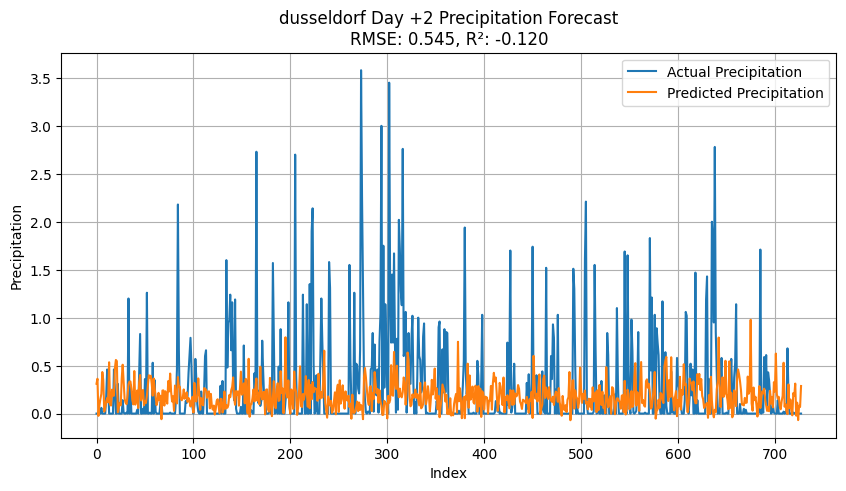

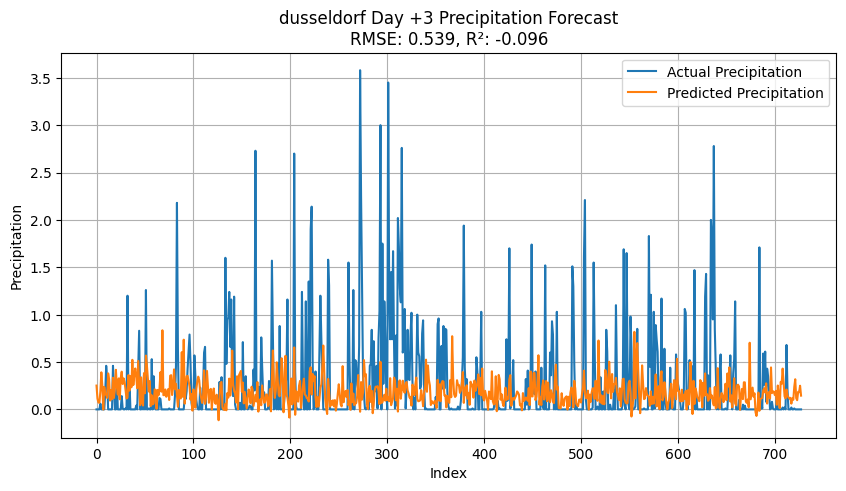

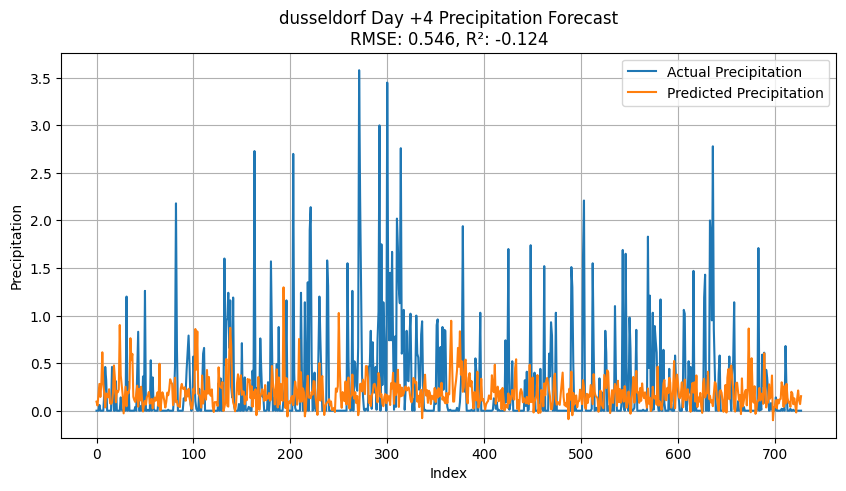

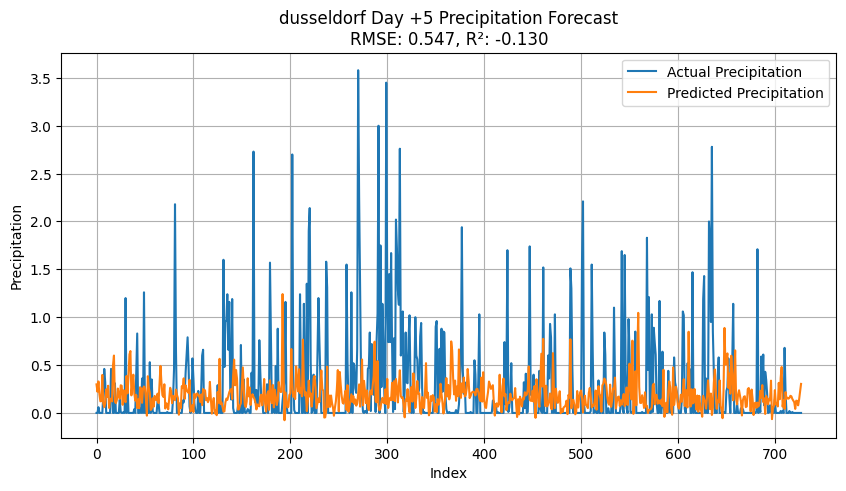

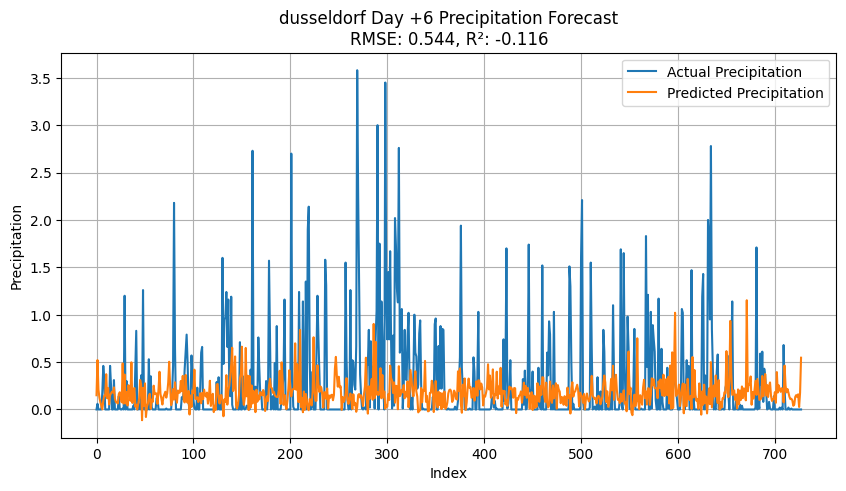

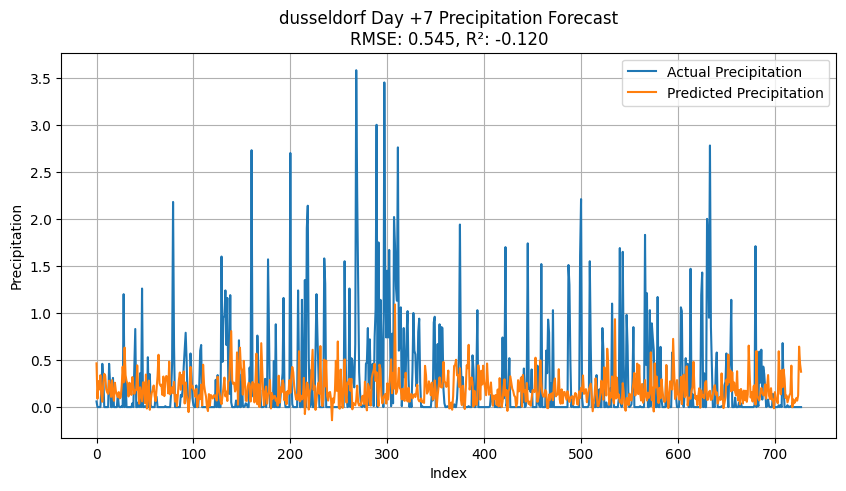

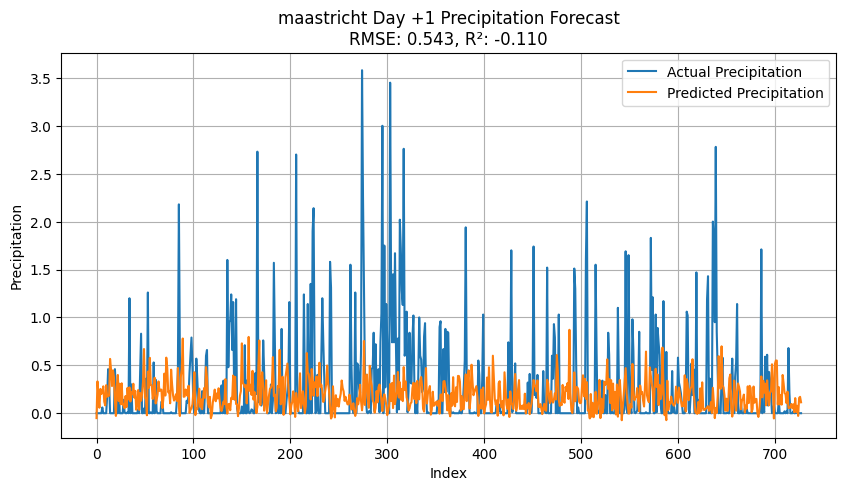

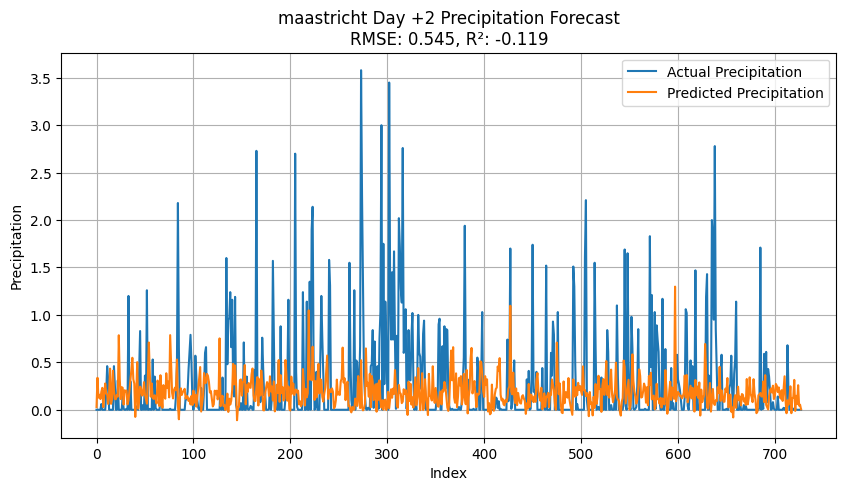

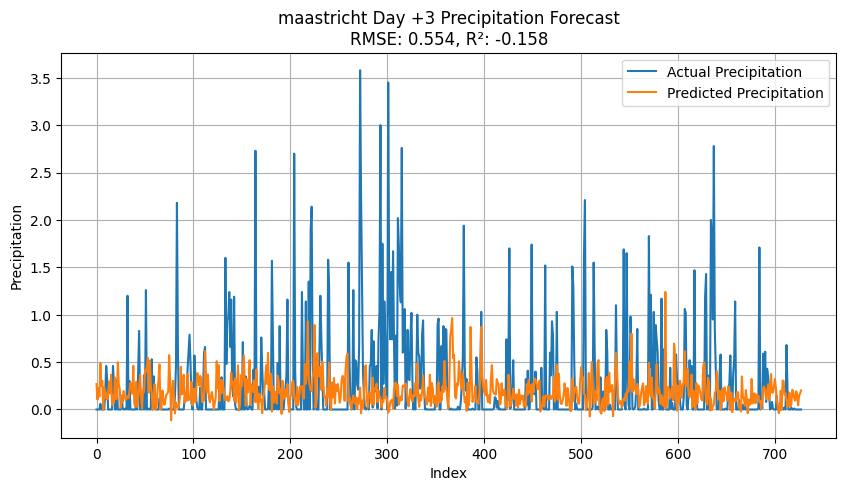

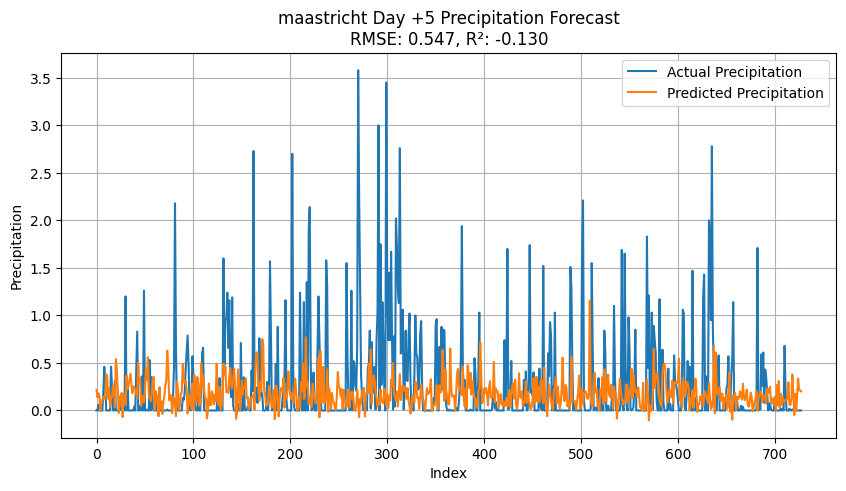

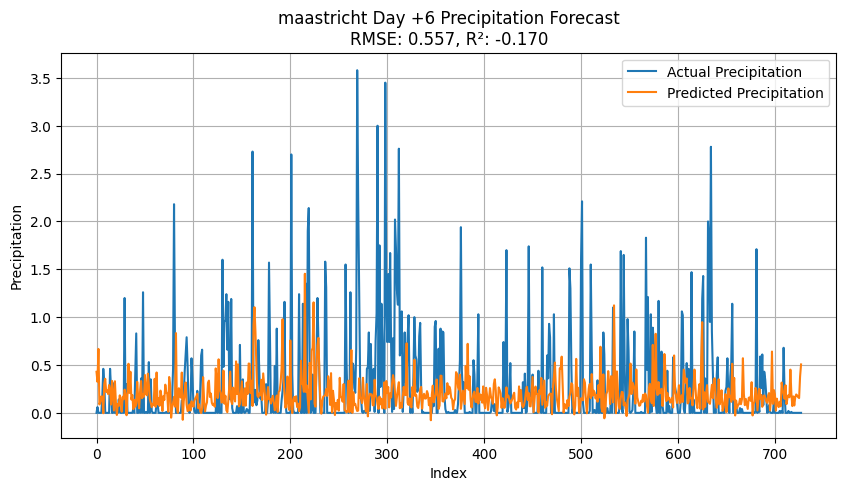

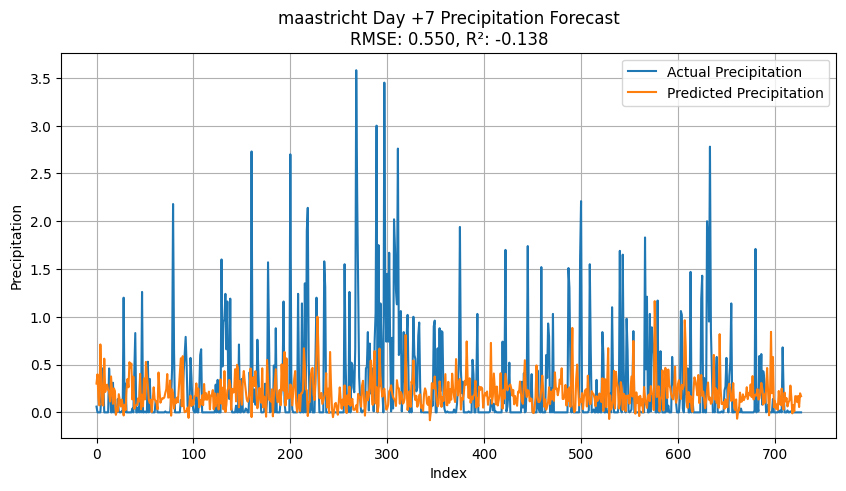

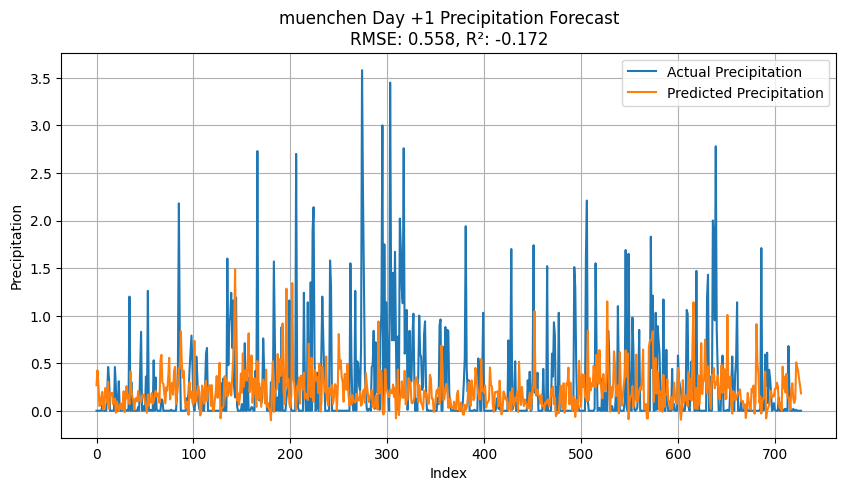

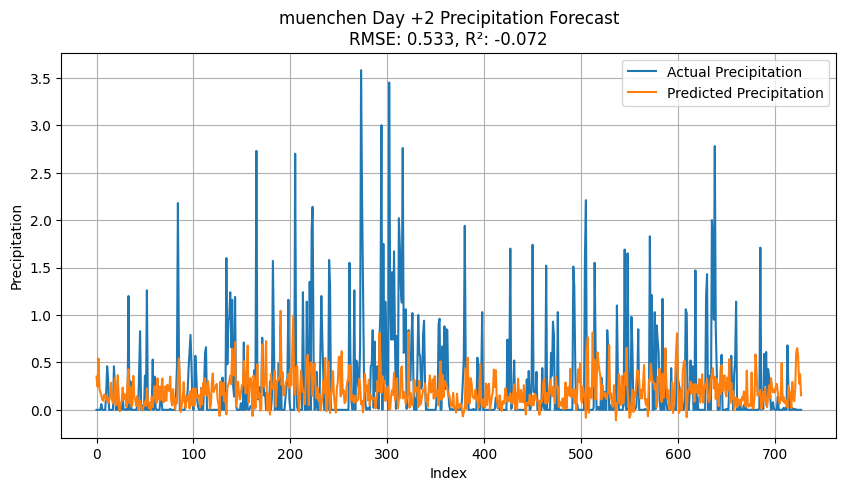

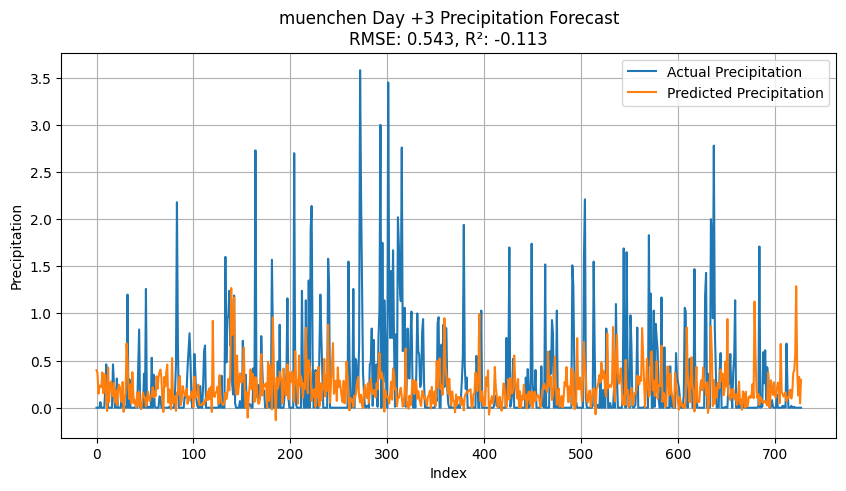

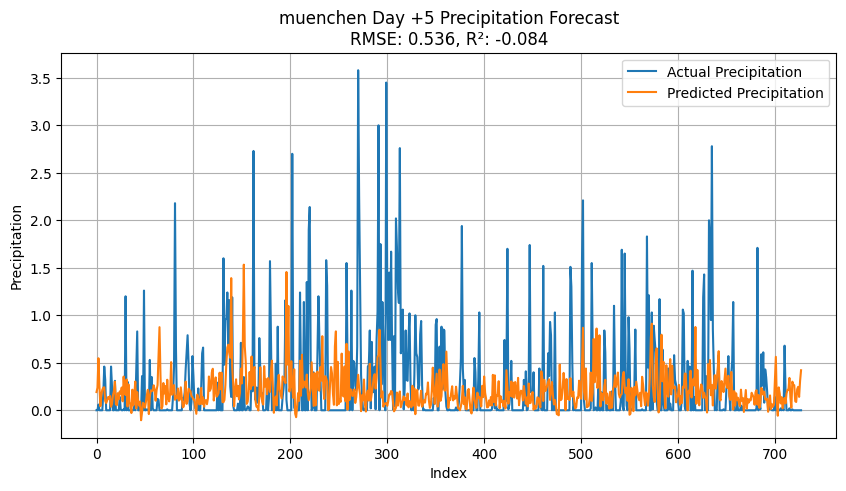

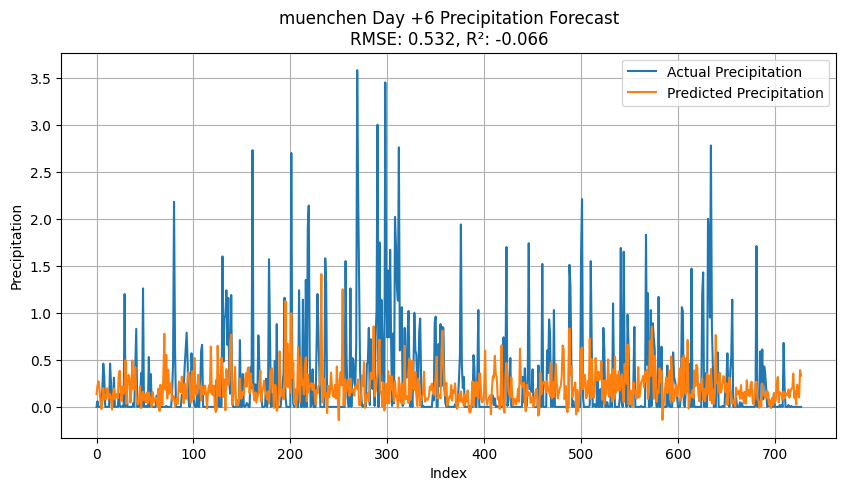

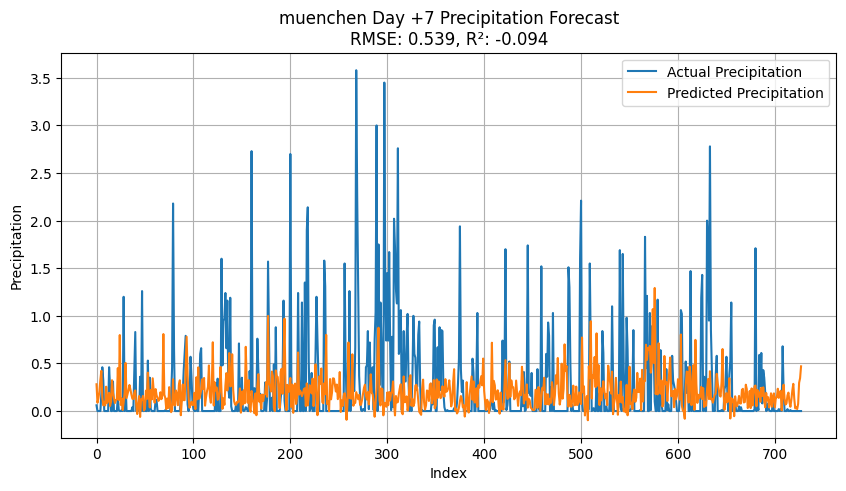

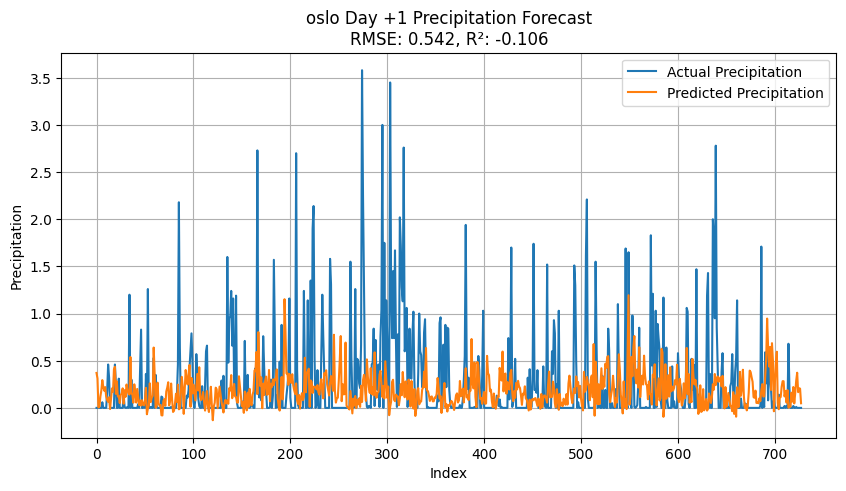

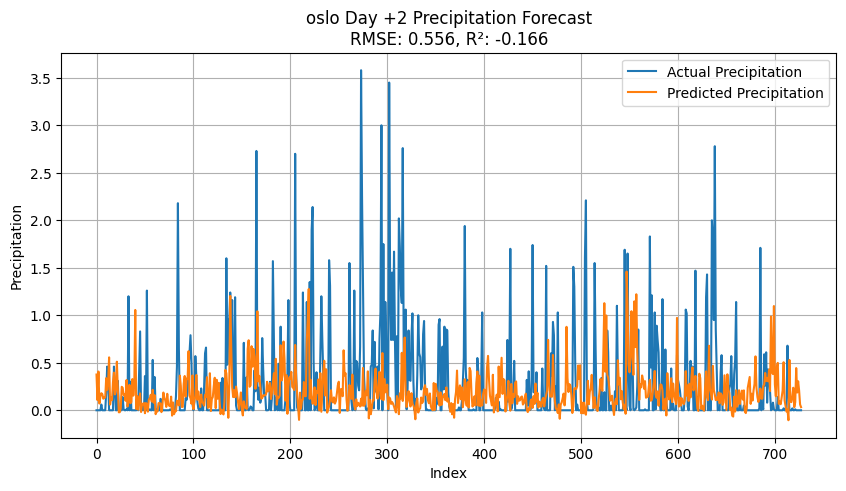

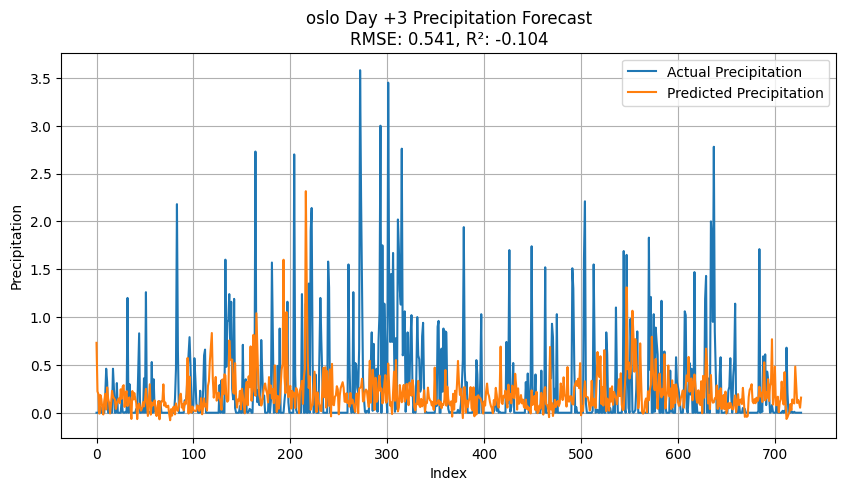

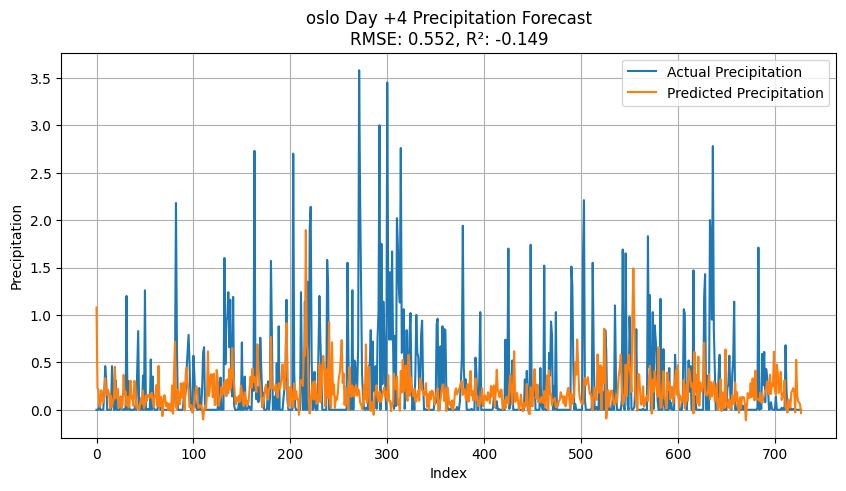

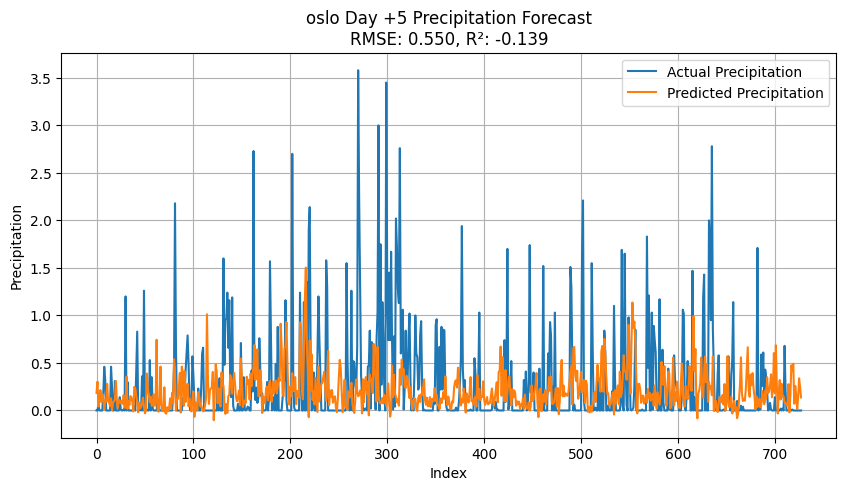

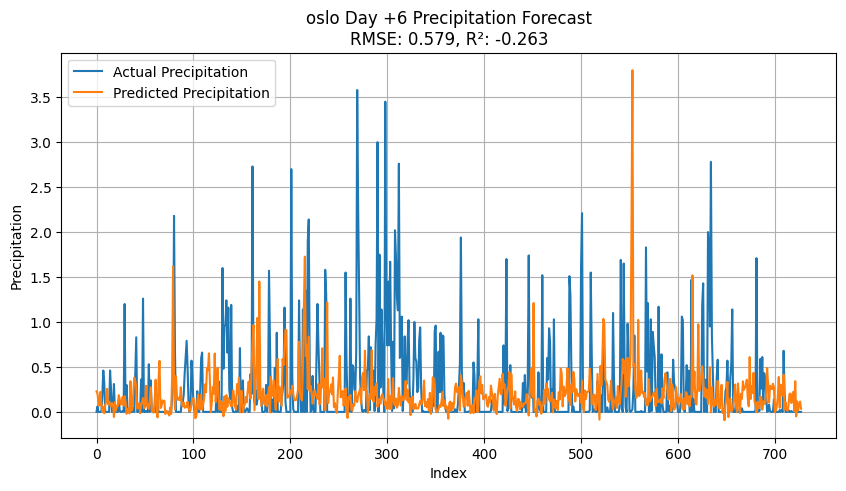

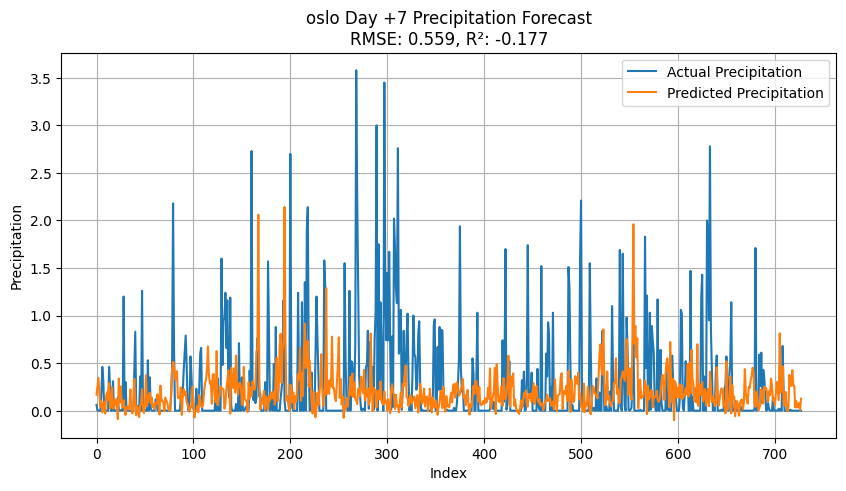

In [160]:
def plot_forecast(city, day_ahead, idx, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    plt.figure(figsize=(10,5))
    plt.plot(idx, y_true, label='Actual Precipitation')
    plt.plot(idx, y_pred, label='Predicted Precipitation')
    plt.title(f'{city} Day +{day_ahead} Precipitation Forecast\nRMSE: {rmse:.3f}, R²: {r2:.3f}')
    plt.xlabel('Index')
    plt.ylabel('Precipitation')
    plt.legend()
    plt.grid(True)
    plt.show()



for kota in kota_list:
    for day_ahead in range(1, 8):
        idx, y_pred = predictions[(kota, day_ahead)]
        y_test = df_kota.loc[idx, f'precipitation_day{day_ahead}']  # GANTI DI SINI
        plot_forecast(kota, day_ahead, idx, y_test, y_pred)
